In [47]:
%load_ext hamilton.plugins.jupyter_magic

The hamilton.plugins.jupyter_magic extension is already loaded. To reload it, use:
  %reload_ext hamilton.plugins.jupyter_magic


# Utilities for date viz

This just sets up functions to display a calendar. We'll be able to see the dates that our system produces. 
This uses the builtin [calendar](https://docs.python.org/3/library/calendar.html) module, and draws from 
this [recipe](https://gist.github.com/flutefreak7/53f7b36baaa122cfbfe18ebf83b6f0e3).

We add a few more capabilities -- enabling us to view a date with a colored "scale". This is not particularly important, but it does make this
more fun.

In [48]:
import calendar
from IPython.display import HTML,display_html 
from calendar import HTMLCalendar
import pandas as pd
import datetime

class HighlightedCalendar(HTMLCalendar):
    def __init__(self, highlight=[], normalized_scale=[], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._highlight = highlight
        self._normalized_scale = normalized_scale
    
    def formatday(self, day, weekday):
        if day in self._highlight:
            index = self._highlight.index(day)
            if len(self._normalized_scale) > 0:
                alpha = self._normalized_scale[index]*.3
            else:
                alpha = 0.3
            return f'<td class="{self.cssclasses[weekday]}" style="background-color:rgba(227, 30, 48, {alpha});">{day}</td>'
        else:
            return super().formatday(day, weekday)

def view_date_range(date_range: pd.Series, scale: pd.Series = None):
    if scale is not None:
        max_scale = max(scale)
        min_scale = min(scale)
        scale = min_scale + (scale-min_scale)/max_scale
    else:
        scale = 1
    html = "<table><tr>"
    month_year_combos = {(date.year, date.month) for date in date_range}
    combined_df = pd.DataFrame(dict(dates=date_range, scale=scale))
    for year, month in month_year_combos:
        filtered_df = combined_df[(combined_df.dates.dt.year == year) & (combined_df.dates.dt.month == month)]
        cal = HighlightedCalendar(highlight=list([item.day for item in filtered_df.dates]), normalized_scale=list(filtered_df.scale))
        html += f"<td>{cal.formatmonth(year, month)}</td>"

    html += "</tr></table>"
    display_html(HTML(html))

# Constants
These are constants we'll use (largely dates) for the rest of the notebook.
Change to be yours.

In [49]:
# Start date of the pregnancy (first of the last period)
PREGNANCY_START_DATE = datetime.datetime.strptime("20231012", "%Y%m%d")

# Today -- set to the past if you don't want a true conditional probability 
TODAY = datetime.datetime.today()

# Computing dates

This is a hamilton module that computes date range. In the first cell, we define two functions. In the next cell, we instantiate it in a driver,
and visualize the possible dates. These are just the date ranges we care about, we'll compute the *probable* dates later.

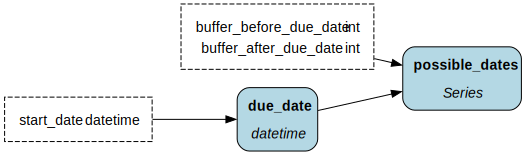

In [50]:
%%cell_to_module -m base_dates --display

import pandas as pd
import datetime

def due_date(start_date: datetime.datetime) -> datetime.datetime:
    """The due date is start_date + 40 weeks. Start date is the date of the expecting mother's last period"""
    return start_date + datetime.timedelta(weeks=40)
    
def possible_dates(due_date: datetime.datetime, buffer_before_due_date:int=8*7, buffer_after_due_date:int=4*7) -> pd.Series:
    """Gets all the reasonably possible dates (-8 weeks, + 4 weeks) of delivery"""
    idx = pd.date_range(
        due_date-datetime.timedelta(days=buffer_before_due_date),
        due_date+datetime.timedelta(days=buffer_after_due_date)
    )
    return pd.Series(data=idx, index=idx)

# Computing Probability Distributions

This cell defines functions to compute the probabilities. Note that we have hardcoded the probability distribution -- see the end of the notebook for how we figured this out.

We have:
1. The probability_distribution -- a continuous distribution
2. The full pdf (probability distribution function). This does two clever things
    a. Readjusts the probability given the current date (see code). You can pass a current_date of `None` if you want to bypass
    b. Again readjusts the probability given the date after which they will induce. You can pass an `induction_post_due_date_days` of something large if you don't want to think about it.

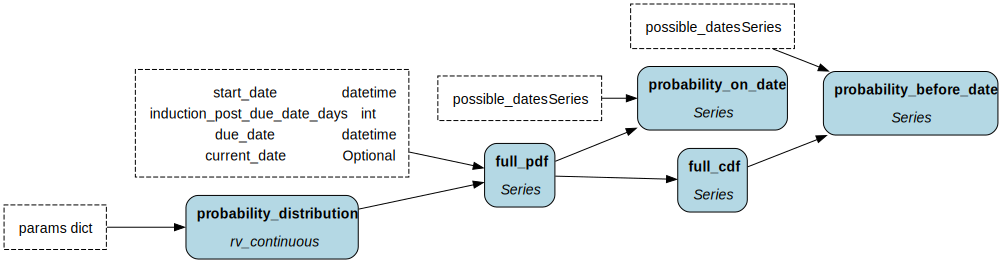

In [51]:
%%cell_to_module -m probabilities --display 
import pandas as pd
import datetime
from scipy import stats
from typing import Optional

PARAMS = {
    'a': -4.186168447183817,
    'loc': 294.44465059093034,
    'scale': 20.670154416450384
}

def probability_distribution(params: dict=PARAMS) -> stats.rv_continuous:
    return stats.skewnorm(**params)
    
def full_pdf(
    start_date: datetime.datetime, 
    due_date: datetime.datetime,
    probability_distribution: stats.rv_continuous,
    current_date: Optional[datetime.datetime]=None,
    induction_post_due_date_days:int=14,
) -> pd.Series:
    all_dates = pd.date_range(start_date, start_date + datetime.timedelta(days=365)) # Wide range but we'll cut it down later
    raw_pdf = probability_distribution.pdf([(item-pd.Timestamp(start_date)).days for item in all_dates])
    pdf = pd.Series(index=all_dates, data=raw_pdf)
    if current_date is not None:
        # Use a simple parficle filter approach: https://en.wikipedia.org/wiki/Particle_filter
        pdf[pdf.index < current_date] = 0
    # we want to normalize as have truncated it (either to a finite range (0,365d) or to the specific range)
    # Although the probabilities at 0/365 days are so small it won't really matter
    pdf_sum = sum(pdf)
    pdf = pdf/pdf_sum
    induction_date = due_date + datetime.timedelta(days=induction_post_due_date_days)
    probability_past_induction_date = sum(pdf[pdf.index > induction_date])
    # zero out everything greater than the induction date 
    pdf[pdf.index > induction_date] = 0
    # and give it to the induction date
    pdf[induction_date] = probability_past_induction_date
    return pdf

def full_cdf(
    full_pdf: pd.Series
) -> pd.Series:
    """Probability of delivery prior to X date on the *full* date range. We'll filter later."""
    return full_pdf.cumsum()

def probability_on_date(full_pdf: pd.Series, possible_dates: pd.Series) -> pd.Series:
    """Probability of deliver *on* a date for every date in the specified date range"""
    return full_pdf[possible_dates]
    
def probability_before_date(full_cdf: pd.Series, possible_dates: pd.Series) -> pd.Series:
    """Probability of delivery *before* a date for every date in the specified date range"""
    return full_cdf[possible_dates]

# Analysis

We run the code and look at the distribution here -- the clanedar display highlights by likelihood (on that day).
The plots show CDF/PDF.

In [52]:
from hamilton import driver, base
from hamilton import log_setup


dr = driver.Builder().with_modules(base_dates, probabilities).with_adapters(base.PandasDataFrameResult()).build()
delivery_probabilities = dr.execute(
    ["possible_dates", "probability_before_date", "probability_on_date"], 
    inputs={"start_date" : PREGNANCY_START_DATE, "current_date": datetime.datetime.now()}
)
view_date_range(delivery_probabilities["possible_dates"], delivery_probabilities["probability_on_date"])

May 2024 
 Mon Tue Wed Thu Fri Sat Sun 
     1 2 3 4 5 
 6 7 8 9 10 11 12 
 13 14 15 16 17 18 19 
 20 21 22 23 24 25 26 
 27 28 29 30 31     
 
 
 June 2024 
 Mon Tue Wed Thu Fri Sat Sun 
           1 2 
 3 4 5 6 7 8 9 
 10 11 12 13 14 15 16 
 17 18 19 20 21 22 23 
 24 25 26 27 28 29 30 
 
 
 July 2024 
 Mon Tue Wed Thu Fri Sat Sun 
 1 2 3 4 5 6 7 
 8 9 10 11 12 13 14 
 15 16 17 18 19 20 21 
 22 23 24 25 26 27 28 
 29 30 31         
 
 
 August 2024 
 Mon Tue Wed Thu Fri Sat Sun 
       1 2 3 4 
 5 6 7 8 9 10 11 
 12 13 14 15 16 17 18 
 19 20 21 22 23 24 25 
 26 27 28 29 30 31

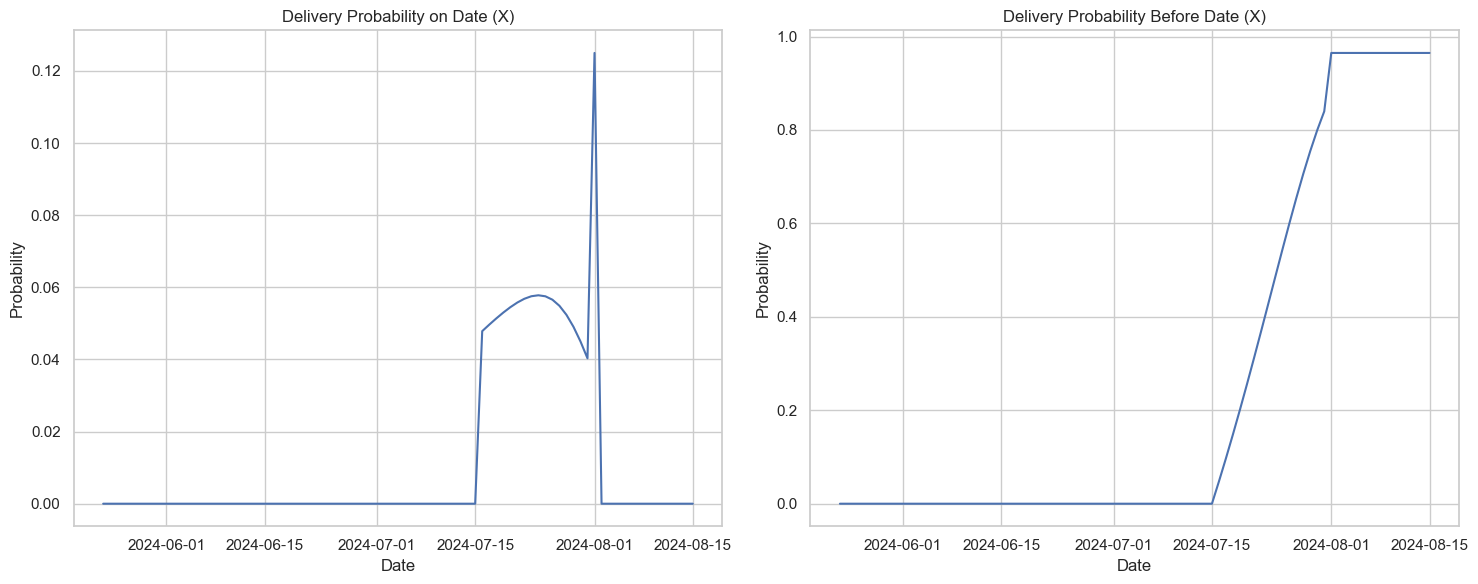

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  # Adjust the figure size as necessary

sns.lineplot(ax=axes[0], data=delivery_probabilities['probability_on_date']).set_title('Delivery Probability on Date (X)')
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Date')

sns.lineplot(ax=axes[1], data=delivery_probabilities['probability_before_date']).set_title('Delivery Probability Before Date (X)')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Date')

plt.tight_layout()

plt.show()

# Determining Probability Distributions

Unfortunately, the one paper that has the parameters for the due date was buried [here](https://www.sciencedirect.com/science/article/pii/S0029784400011315?casa_token=yV-QZInYkl8AAAAA:0U_Z2dT-r0y1etlX8hRG5ulyrjtzoVXRXIlvJkcSyXhtllUlkhWPNr5f3MJL0LMFzHZv5TwsN4Q), behind a paywall.

So, we used the calculator [here](https://datayze.com/labor-probability-calculator) and *fit* the parameters after the due date.

Kids, this is not great data science, but it works nicely. We:
1. Parse the data
2. Resample
3. Use sklearn.skewnorm.fit()
4. Return the parameters

This is a dumb way to get it to use `sklearn.skewnorm.fit()` -- in reality we can optimize it to fit the PDF curve. Or read the library more for the right function. That said, the code here is simple
and easy. The lesson is that most of what we call data science is often clever hacks to get the numbers to look good, and they work!

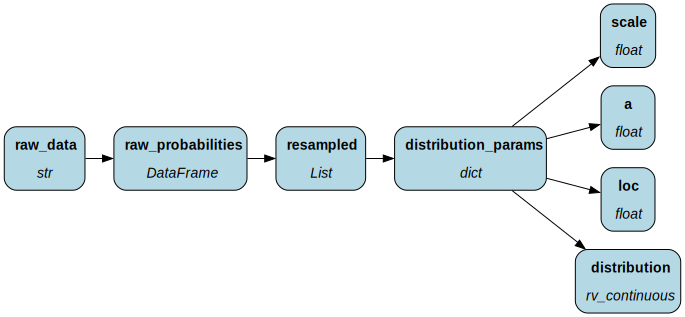

In [54]:
%%cell_to_module -m probability_estimation --display

from scipy import stats
import pandas as pd
from typing import List
from hamilton.function_modifiers import extract_fields

def raw_data() -> str:
    s = """31 weeks	< 0.1%	< 0.1%	> 99.9%
31 weeks, 1 day	< 0.1%	< 0.1%	> 99.9%
31 weeks, 2 days	< 0.1%	< 0.1%	> 99.9%
31 weeks, 3 days	< 0.1%	< 0.1%	> 99.9%
31 weeks, 4 days	0.1%	< 0.1%	99.9%
31 weeks, 5 days	0.1%	< 0.1%	99.9%
31 weeks, 6 days	0.1%	< 0.1%	99.9%
32 weeks	0.1%	< 0.1%	99.9%
32 weeks, 1 day	0.1%	< 0.1%	99.9%
32 weeks, 2 days	0.1%	< 0.1%	99.9%
32 weeks, 3 days	0.1%	< 0.1%	99.8%
32 weeks, 4 days	0.2%	< 0.1%	99.8%
32 weeks, 5 days	0.2%	< 0.1%	99.8%
32 weeks, 6 days	0.2%	< 0.1%	99.7%
33 weeks	0.3%	< 0.1%	99.7%
33 weeks, 1 day	0.3%	< 0.1%	99.6%
33 weeks, 2 days	0.4%	0.1%	99.6%
33 weeks, 3 days	0.4%	0.1%	99.5%
33 weeks, 4 days	0.5%	0.1%	99.4%
33 weeks, 5 days	0.6%	0.1%	99.3%
33 weeks, 6 days	0.7%	0.1%	99.2%
34 weeks	0.8%	0.1%	99.1%
34 weeks, 1 day	0.9%	0.1%	99%
34 weeks, 2 days	1%	0.1%	98.9%
34 weeks, 3 days	1.2%	0.1%	98.7%
34 weeks, 4 days	1.3%	0.2%	98.5%
34 weeks, 5 days	1.5%	0.2%	98.3%
34 weeks, 6 days	1.7%	0.2%	98.1%
35 weeks	2%	0.2%	97.8%
35 weeks, 1 day	2.2%	0.3%	97.5%
35 weeks, 2 days	2.5%	0.3%	97.2%
35 weeks, 3 days	2.9%	0.3%	96.8%
35 weeks, 4 days	3.2%	0.4%	96.4%
35 weeks, 5 days	3.6%	0.4%	96%
35 weeks, 6 days	4.1%	0.4%	95.5%
36 weeks	4.6%	0.5%	95%
36 weeks, 1 day	5.1%	0.5%	94.4%
36 weeks, 2 days	5.7%	0.6%	93.7%
36 weeks, 3 days	6.3%	0.6%	93%
36 weeks, 4 days	7%	0.7%	92.2%
36 weeks, 5 days	7.8%	0.8%	91.4%
36 weeks, 6 days	8.7%	0.8%	90.5%
37 weeks	9.6%	0.9%	89.5%
37 weeks, 1 day	10.6%	1%	88.5%
37 weeks, 2 days	11.6%	1.1%	87.3%
37 weeks, 3 days	12.8%	1.1%	86.1%
37 weeks, 4 days	14%	1.2%	84.8%
37 weeks, 5 days	15.3%	1.3%	83.4%
37 weeks, 6 days	16.7%	1.4%	81.8%
38 weeks	18.3%	1.5%	80.2%
38 weeks, 1 day	19.9%	1.6%	78.5%
38 weeks, 2 days	21.6%	1.7%	76.7%
38 weeks, 3 days	23.4%	1.8%	74.8%
38 weeks, 4 days	25.3%	1.9%	72.8%
38 weeks, 5 days	27.4%	2%	70.6%
38 weeks, 6 days	29.5%	2.1%	68.4%
39 weeks	31.7%	2.2%	66%
39 weeks, 1 day	34.1%	2.4%	63.5%
39 weeks, 2 days	36.6%	2.5%	61%
39 weeks, 3 days	39.1%	2.6%	58.3%
39 weeks, 4 days	41.8%	2.7%	55.5%
39 weeks, 5 days	44.6%	2.8%	52.6%
39 weeks, 6 days	47.5%	2.9%	49.6%
40 weeks	50.5%	3%	46.5%
40 weeks, 1 day	53.6%	3.1%	43.4%
40 weeks, 2 days	56.7%	3.2%	40.1%
40 weeks, 3 days	59.9%	3.2%	36.8%
40 weeks, 4 days	63.2%	3.3%	33.5%
40 weeks, 5 days	66.5%	3.3%	30.2%
40 weeks, 6 days	69.8%	3.3%	26.9%
41 weeks	73.1%	3.3%	23.6%
41 weeks, 1 day	76.3%	3.2%	20.4%
41 weeks, 2 days	79.5%	3.1%	17.4%
41 weeks, 3 days	82.4%	3%	14.6%
41 weeks, 4 days	85.2%	2.8%	12%
41 weeks, 5 days	87.8%	2.6%	9.6%
41 weeks, 6 days	90.1%	2.3%	7.5%
42 weeks	92.2%	2%	5.8%
42 weeks, 1 day	93.9%	1.8%	4.3%
42 weeks, 2 days	95.4%	1.5%	3.1%
42 weeks, 3 days	96.6%	1.2%	2.2%
42 weeks, 4 days	97.6%	0.9%	1.5%
42 weeks, 5 days	98.3%	0.7%	1%
42 weeks, 6 days	98.8%	0.5%	0.6%
43 weeks	99.2%	0.4%	0.4%
43 weeks, 1 day	99.5%	0.3%	0.2%
43 weeks, 2 days	99.7%	0.2%	0.1%
43 weeks, 3 days	99.8%	0.1%	0.1%
43 weeks, 4 days	99.9%	0.1%	< 0.1%
43 weeks, 5 days	99.9%	< 0.1%	< 0.1%
43 weeks, 6 days	> 99.9%	< 0.1%""".replace("weeks\t", "weeks, 0 days ").replace("\t", " ").split("\n")
    return s

def raw_probabilities(raw_data: str) -> pd.DataFrame:
    # filter out the outliers, we'll want them back in at some point but we'll let the fitting do the job
    raw_data = [item for item in raw_data if "<" not in item and ">" not in item]    
    weeks = [int(item.split(',')[0].split()[0]) for item in raw_data if "<" not in raw_data and ">" not in raw_data]
    days = [int(item.split(', ')[1].split()[0]) for item in raw_data]
    probability = [float(item.split()[5].replace("%", ""))/100 for item in raw_data]
    probabilities_data = [(week*7+day, probability) for week, day, probability in zip(weeks, days, probability)]
    probabilities_df = pd.DataFrame(probabilities_data)
    probabilities_df.columns=["days", "probability"]
    return probabilities_df#.set_index("days")

def resampled(raw_probabilities: pd.DataFrame) -> List[int]:
    sample_data = []
    for index, row in raw_probabilities.iterrows():
        count = row.probability*100000
        for i in range(int(count)):
            sample_data.append(row.days)
    return sample_data

@extract_fields(
    fields={"a" : float, "loc": float, "scale" : float}
)
def distribution_params(resampled: list[int]) -> dict[str, float]:
    a, loc, scale = stats.skewnorm.fit(resampled)
    return {
        "a": a,
        "loc" : loc,
        "scale" : scale
    }

def distribution(distribution_params: dict[str, float]) -> stats.rv_continuous:
    return stats.skewnorm(**distribution_params)

In [55]:
dr = driver.Builder().with_modules(probability_estimation).build()
params = dr.execute(["a", "scale", "loc"])
params

{'a': -4.173809457546488,
 'scale': 20.688472826615758,
 'loc': 294.4582205763919}

In [11]:
distr = params['distribution']

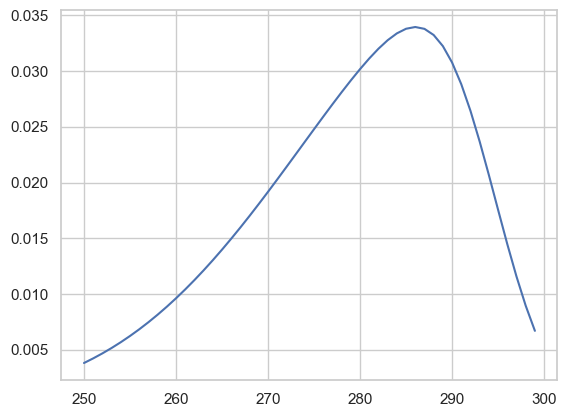

In [12]:
days = list(range(250,300))
pd.Series(distr.pdf(days), index=days).plot()
sns.set(style="whitegrid")


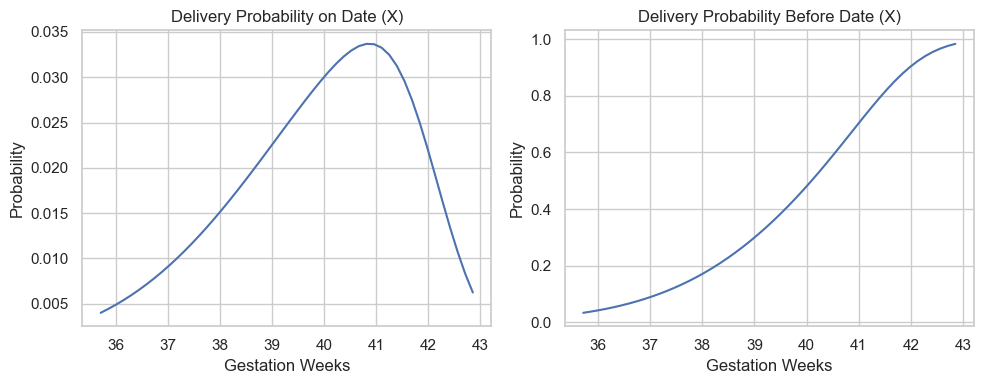

In [30]:
import scipy
distr = scipy.stats.skewnorm(a=-4, loc=294, scale=20.67)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # Adjust the figure size as necessary

x = np.linspace(250,300)
data = pd.DataFrame(index=x/7, data=dict(pdf=distr.pdf(days), cdf=distr.cdf(days)))
sns.lineplot(ax=axes[0], data=data["pdf"]).set_title('Delivery Probability on Date (X)')
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Gestation Weeks')

sns.lineplot(ax=axes[1], data=data["cdf"]).set_title('Delivery Probability Before Date (X)')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Gestation Weeks')

plt.tight_layout()

plt.show()

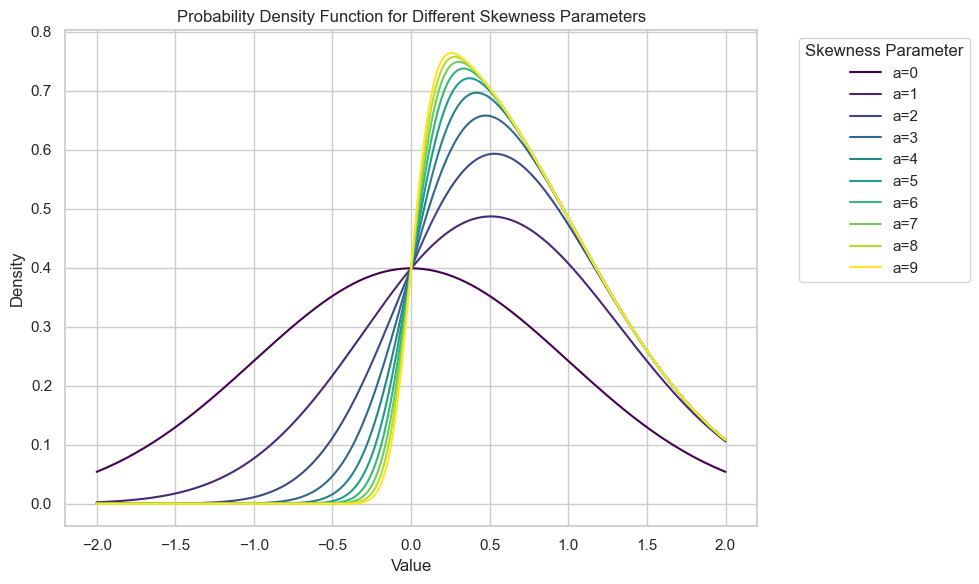

In [14]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

# Define the series and create space
series = {}
space = np.linspace(-2, 2, 200)

# Create skewed normal distributions for different values of 'a'
for a in range(0, 10):
    distr = scipy.stats.skewnorm(a=a, loc=0, scale=1)
    series[str(a)] = pd.Series(distr.pdf(space), index=space)

# Convert series dictionary to DataFrame
df = pd.DataFrame(series)

# Set up seaborn with whitegrid style
sns.set(style="whitegrid")

# Generate the plot with a color gradient
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df.columns)))  # Generate a color map
for i, column in enumerate(df.columns):
    sns.lineplot(x=df.index, y=df[column], label=f'a={column}', color=colors[i])
plt.title('Probability Density Function for Different Skewness Parameters')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Skewness Parameter', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


In [46]:
?%%cell_to_module

Docstring:
::

  %cell_to_module [-m [MODULE_NAME]] [-d [DISPLAY]] [-x [EXECUTE]]
                      [-b BUILDER] [-c CONFIG] [-i INPUTS] [-o OVERRIDES]
                      [--hide_results] [-w [WRITE_TO_FILE]]
                      [name]

Turn a notebook cell into a Hamilton module definition. This allows you to define
and execute a dataflow from a single cell.

For example:
```
%%cell_to_module dataflow --display --execute
def A() -> int:
  return 37

def B(A: int) -> bool:
  return (A % 3) > 2
```

positional arguments:
  name                  Name for the module defined in this cell.

options:
  -m <[MODULE_NAME]>, --module_name <[MODULE_NAME]>
                        Alias for positional argument `module_name`. There for
                        backwards compatibility. Prefer the position arg.
  -d <[DISPLAY]>, --display <[DISPLAY]>
                        Display the dataflow. The argument is the variable
                        name of a dictionary of visualization kwargs;